# Preprocessing Quality Control

This notebook verifies the results of the GPU-accelerated preprocessing pipeline.
We will load the processed file `sea_ad_proc.h5ad`, check for PCA embeddings, and run UMAP to visualize cell clusters.

In [5]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
# Config
data_path = "../data/processed/sea_ad_proc.h5ad"

print(f"Loading {data_path}...")
# Load fully into memory (it's metadata only mostly) or backed
adata = sc.read_h5ad(data_path, backed='r+')
print(adata)

Loading ../data/processed/sea_ad_proc.h5ad...
AnnData object with n_obs × n_vars = 1040014 × 36601 backed at '..\\data\\processed\\sea_ad_proc.h5ad'
    obs: 'library_prep', 'Donor ID', 'Method', 'Sex', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'Hispanic/Latino', 'Years of education', 'PMI', 'APOE Genotype', 'Thal', 'Braak', 'CERAD', 'ADNC', 'LATE', 'Highest Lewy Body Disease', 'Cognitive Status', 'Class', 'Subclass', 'Supertype', 'percent 6e10 positive area', 'percent AT8 positive area', 'percent NeuN positive area', 'percent GFAP positive area', 'percent aSyn positive area', 'percent pTDP43 positive area', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt'
    var: 'gene_ids'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'


## 1. Inspect PCA
We check if `X_pca` exists in `.obsm`. If variance info is missing from `.uns`, we skip the explained variance plot.

✅ PCA embeddings found in adata.obsm['X_pca']
Shape: (1040014, 50)


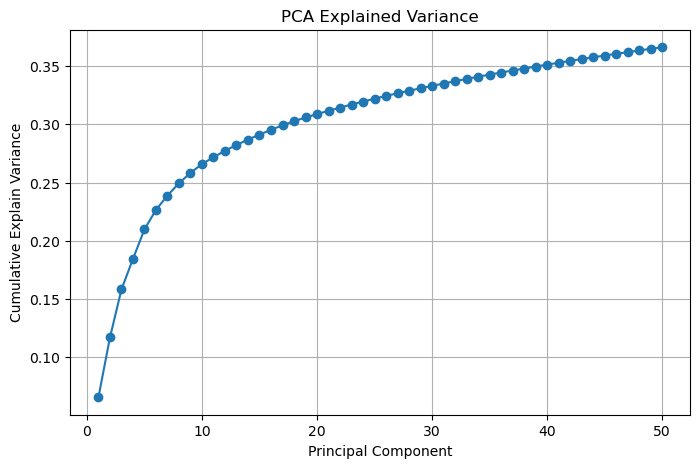

In [7]:
if 'X_pca' in adata.obsm:
    print("✅ PCA embeddings found in adata.obsm['X_pca']")
    print(f"Shape: {adata.obsm['X_pca'].shape}")
else:
    print("❌ PCA embeddings NOT found! Something went wrong.")

# Check for variance info
if 'pca' in adata.uns and 'variance_ratio' in adata.uns['pca']:
    var_ratio = adata.uns['pca']['variance_ratio']
    cumulative_var = np.cumsum(var_ratio)
    
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(var_ratio)+1), cumulative_var, marker='o')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explain Variance')
    plt.grid(True)
    plt.title(f'PCA Explained Variance')
    plt.show()
else:
    print("⚠️ PCA variance metadata not found in .uns['pca']. Skipping plot.")

## 2. Compute Neighborhood Graph & UMAP
We compute the neighbor graph on the CPU (using the PCA embeddings) and then run UMAP.

Creating in-memory view for UMAP...
Computing Neighbors...


c:\Users\thoma\miniconda3\envs\brain-gnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running UMAP (this may take 30-60s)...
Plotting UMAP...


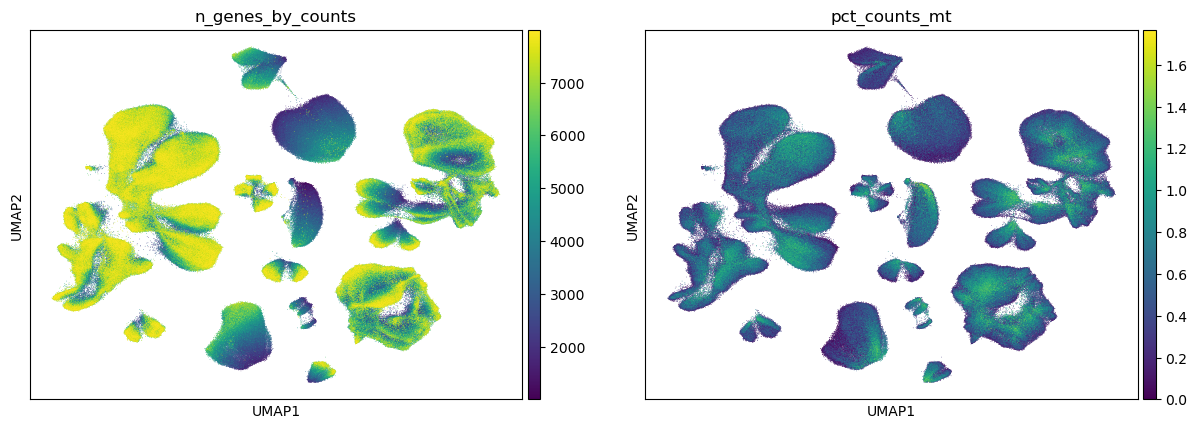

In [ ]:
# Create an in-memory AnnData for UMAP visualization to avoid read-only/locking issues with backed file
print("Creating in-memory view for UMAP...")
adata_vis = sc.AnnData(obs=adata.obs)
adata_vis.obsm['X_pca'] = adata.obsm['X_pca'][:]

print("Computing Neighbors...")
# Explicitly specify use_rep='X_pca' to avoid ambiguity since .X is None
sc.pp.neighbors(adata_vis, n_neighbors=15, n_pcs=50, use_rep='X_pca')

print("Running UMAP (this may take 10-15min)...")
sc.tl.umap(adata_vis)

print("Plotting UMAP...")
sc.pl.umap(adata_vis, color=['n_genes_by_counts', 'pct_counts_mt'], size=1)